In [ ]:
# for folder in os.listdir("dummyDataset"):
# #     print(folder)
#     x = folder.split('db')
#     folder_path = os.path.join('dummyDataset    for subfolder in os.listdir(folder_path):
#     subfolder_path = os.path.join(folder_path,subfolder)
#     for subfolder in os.listdir(folder_path):
#         subfolder_path = os.path.join(folder_path,subfolder)
#         if os.path.isdir(subfolder_path):
#             for sub_sub in os.listdir(subfolder_path):
#                 if os.path.isdir(os.path.join(subfolder_path, sub_sub)):
#                     for image in os.listdir(os.path.join(subfolder_path, sub_sub)):
#                         src= os.path.join(subfolder_path, sub_sub, image)
#                         dst = os.path.join(subfolder_path, sub_sub, x[1]+'_'+image)
#                         os.rename(src, dst)
                        
#                 else:
#                     src= os.path.join(subfolder_path, sub_sub)
#                     dst = os.path.join(subfolder_path, x[1]+'_'+sub_sub)
#                     os.rename(src, dst)

In [5]:
import os, glob
import sys
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [2]:
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory. 
    Only filesnames matching filepattern will be considered"""
    
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
    print ('\tRead Dicom',directory)
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print ('\tLength dicom series',len(lstFilesDCM))
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

    return ArrayDicom

def read_liver_lesion_masks(masks_dirname):
    """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
    we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
    Args:
        masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
                        one for each labelled mask
    Returns:
        numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
    """
    tumor_volume = None
    liver_volume = None
    
    # For each relevant organ in the current volume
    for organ in os.listdir(masks_dirname):
        organ_path = os.path.join(masks_dirname,organ)
        if not os.path.isdir(organ_path):
            continue
        
        organ = organ.lower()
        
        if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
            print('Organ',masks_dirname,organ)
            current_tumor = read_dicom_series(organ_path)
            current_tumor = np.clip(current_tumor,0,1)
            # Merge different tumor masks into a single mask volume
            tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        elif organ == 'liver':
            print('Organ',masks_dirname,organ)
            liver_volume = read_dicom_series(organ_path)
            liver_volume = np.clip(liver_volume, 0, 1)
    
    # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
    label_volume = np.zeros(liver_volume.shape)
    label_volume[liver_volume==1]=1
    label_volume[tumor_volume==1]=2
    return label_volume    
            
def stat(array):
    print('min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array))
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
#         return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
        return np.array(Image.fromarray(img).resize([height, width])/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [3]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Rotate the input volume so the the liver is on the left, spine is at the bottom of the image
    2- Set pixels with hounsfield value great than 1200, to zero.
    3- Clip all hounsfield values to the range [-100, 400]
    4- Normalize values to [0, 1]
    5- Rescale img and label slices to 388x388
    6- Pad img slices with 92 pixels on all sides (so total shape is 572x572)
    
    Args:
        img_slc: raw image slice
    Return:
        Preprocessed image slice
    """      
    img_slc   = img_slc.astype(IMG_DTYPE)
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)    
#     img_slc   = normalize_image(img_slc)
    img_slc   = to_scale(img_slc, (388,388))
    img_slc   = np.pad(img_slc,((62,62),(62,62)),mode='reflect')
    
#     img_slc   = img_slc[:, :, np.newaxis]
    if False:
        img_slc = histeq_processor(img_slc)

    return img_slc

In [6]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
#         print(self.path, id_name)
#         path = os.path.normpath(self.path)
#         x = path.split(os.sep)
        tumor_volume = None
        liver_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_image(image)
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        
#         print(image)
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        for name in all_masks:
            y = id_name.split('_')
            if name.startswith(y[0] + '_livertumor') or name.startswith(y[0] + '_liverkyste') or name.startswith(y[0] +'_tumor'):
                current_tumor = pydicom.dcmread(os.path.join(mask_path, name, id_name)).pixel_array
                current_tumor = current_tumor/255.0
                current_tumor = np.clip(current_tumor,0,1)
                tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
            elif name == y[0] + '_liver':
                liver_volume = pydicom.dcmread(os.path.join(mask_path, name, id_name)).pixel_array
                liver_volume = liver_volume/255.0
                liver_volume = np.clip(liver_volume, 0, 1)
 
        mask = np.zeros(liver_volume.shape)
        mask[liver_volume==1]=1
        mask[tumor_volume==1]=1
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
#         mask = np.pad(liver_volume,((30,30),(30,30)),mode='reflect')
        mask = mask[:, :, np.newaxis]
        ## Reading Masks
#         for name in all_masks:
#             _mask_path = mask_path + name
#             _mask_image = cv2.imread(_mask_path, -1)
#             _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
#             _mask_image = np.expand_dims(_mask_image, axis=-1)
#             mask = np.maximum(mask, _mask_image)
            
#         ## Normalizaing 
#         image = image/255.0
#         mask = mask/255.0
#         imshow(image)
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
    
        for id_name in files_batch:
#             return len(files_batch)
            _img, _mask = self.__load__(id_name)
#             _img = _img.astype(np.uint8)
#             _img = cv2.cvtColor(_img,cv2.COLOR_GRAY2RGB)
#             _img = np.broadcast_to(_img[..., np.newaxis], (128, 128, 3))
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)
#         image = image[:, :, np.newaxis]
#         image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB) 

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [34]:
image_size = 256
train_path = "train"
batch_size = 8
epochs = 10

## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
    images.append(file)
print(len(images))

## Validation Data Size
val_data_size = 400

valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]

2823


In [35]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
# print(train_ids[2])
x, y = gen.__getitem__(0)
# for i in range(0, len(y)):
#     for j in range(0, len(y[i])):
#         for k in range(0, len(y[i][j])):
#             if(y[i][j][k][0] > 0):
#                 print(y[i][j][k][0])
# print(y)
# print(x.shape, y.shape)
# print(gen.__getitem__(0))

6


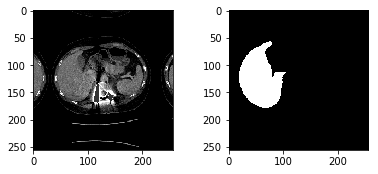

In [36]:
r = random.randint(0, len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [37]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [38]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [40]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
_____________________________________

In [41]:
# os.environ ['CUDA_VISIBLE_DEVICES'] = '1' 
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
# with tf.device('/gpu:0'):
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
303/303 [==============================] - 157s 517ms/step - loss: 0.7766 - acc: 0.9582 - val_loss: 0.4793 - val_acc: 0.9770
Epoch 2/10
303/303 [==============================] - 123s 405ms/step - loss: 0.3811 - acc: 0.9782 - val_loss: 0.3384 - val_acc: 0.9835
Epoch 3/10
303/303 [==============================] - 109s 359ms/step - loss: 0.2498 - acc: 0.9854 - val_loss: 0.2367 - val_acc: 0.9875
Epoch 4/10
303/303 [==============================] - 99s 326ms/step - loss: 0.1834 - acc: 0.9893 - val_loss: 0.1557 - val_acc: 0.9923
Epoch 5/10
303/303 [==============================] - 85s 282ms/step - loss: 0.1384 - acc: 0.9919 - val_loss: 0.1238 - val_acc: 0.9937
Epoch 6/10
303/303 [==============================] - 78s 256ms/step - loss: 0.0993 - acc: 0.9941 - val_loss: 0.1044 - val_acc: 0.9946
Epoch 7/10
303/303 [==============================] - 71s 234ms/step - loss: 0.0912 - acc: 0.9946 - val_loss: 0.0971 - val_acc: 0.9951
Epoc

In [32]:
# with tf.device('/gpu:0'):
#   a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#   b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(c))
print(train_steps, valid_steps)

302 50


In [43]:
# del model
model.save('liver_CNN.h5')  # creates a HDF5 file 'my_model.h5'

# model = keras.models.load_model('my_model.h5')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

(8, 128, 128, 3) (8, 128, 128, 1)


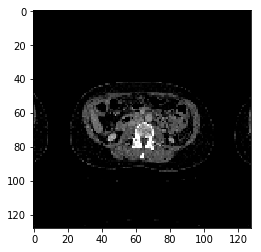

In [35]:
x, y = valid_gen.__getitem__(7)
result = model.predict(x)

result = result > 0.5
print(x.shape, result.shape)

imshow(x[1])

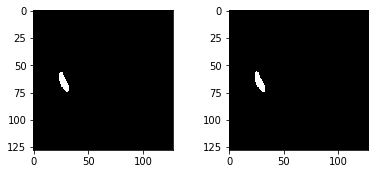

In [36]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

/home/amir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


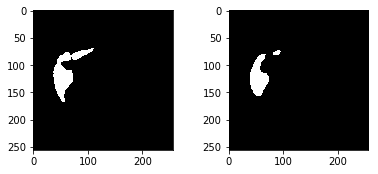

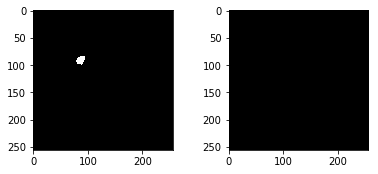

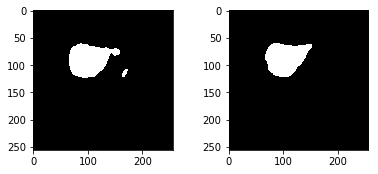

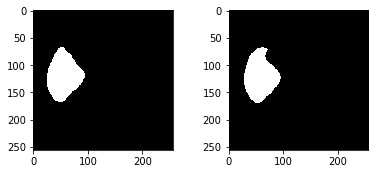

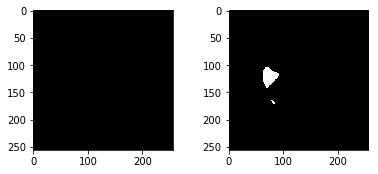

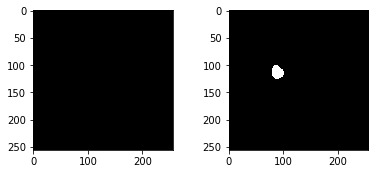

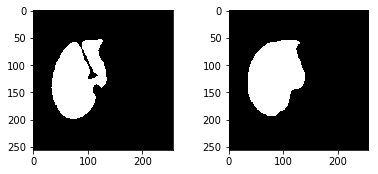

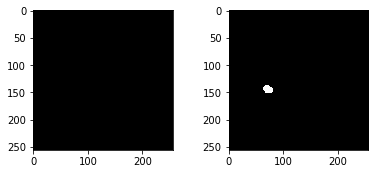

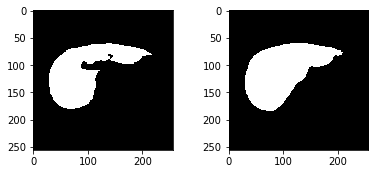

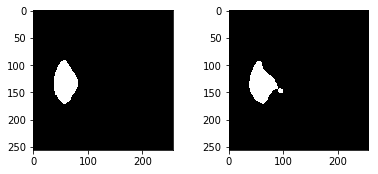

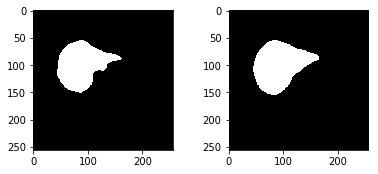

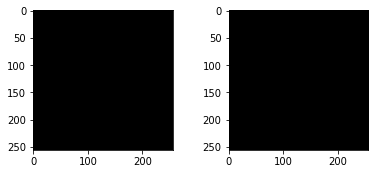

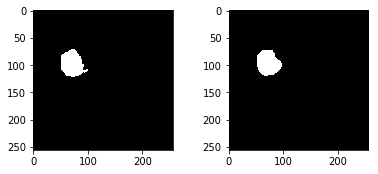

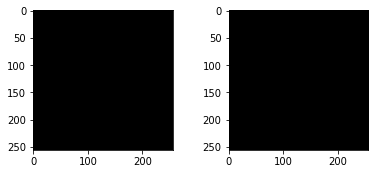

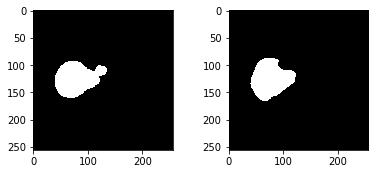

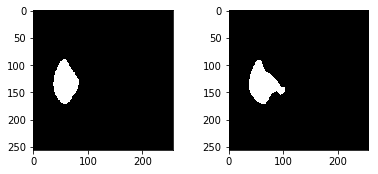

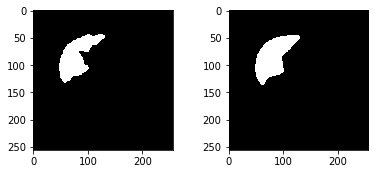

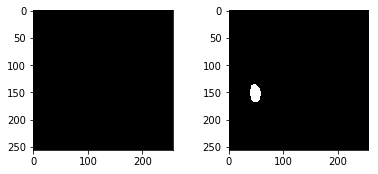

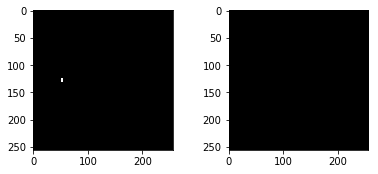

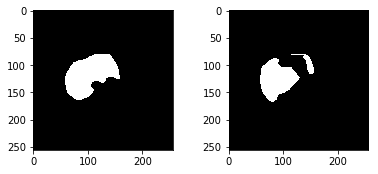

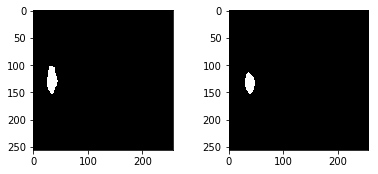

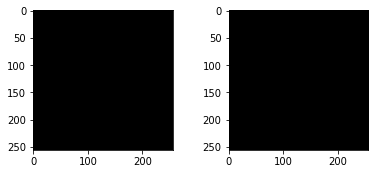

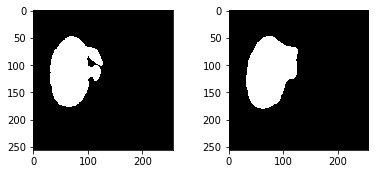

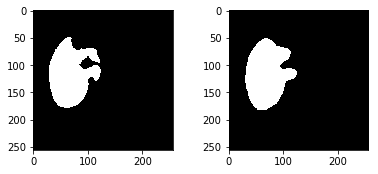

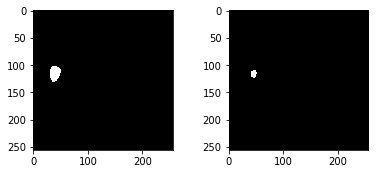

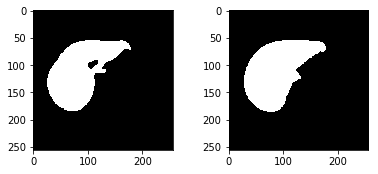

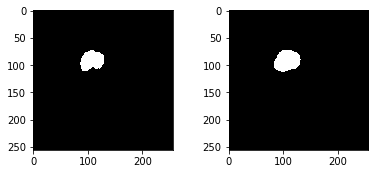

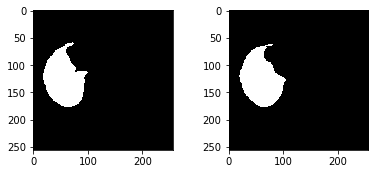

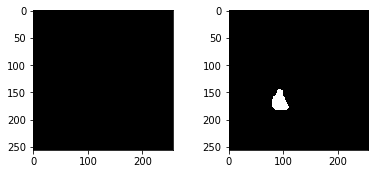

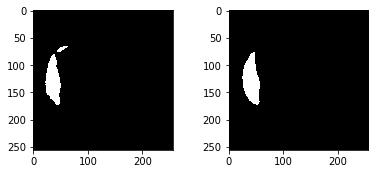

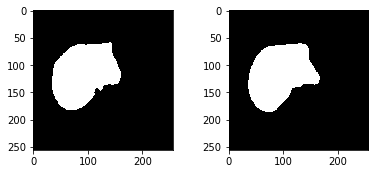

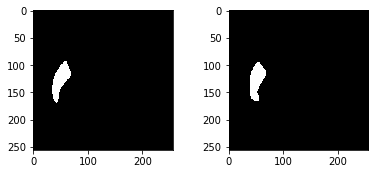

In [42]:
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
    
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")